In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision 
import torchvision.transforms as transforms
from resnet import ResNet18


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        dummy = torch.zeros(1, 1, 32, 32)
        x = self._forward_conv(dummy)
        flattened_size = x.numel()

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

    def _forward_conv(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device) 

MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
transform_train = transforms.Compose([
    transforms.Pad(2), # Pad 28x28 to 32x32
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD) # Updated for MNIST
])

transform_test = transforms.Compose([
    transforms.Pad(2), # Pad 28x28 to 32x32
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD) # Updated for MNIST
])

trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(net.parameters(), lr=1e-3, weight_decay=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
 


In [ ]:

for start_epoch in range(100):
    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {start_epoch+1}, Loss: {running_loss/len(trainloader):.4f}")
    scheduler.step()

    if (start_epoch + 1) % 10 == 0:
        torch.save({
            'epoch': start_epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': running_loss / len(trainloader)
        }, f"checkpoint_epoch_{start_epoch+1}.pth")
        print(f"Checkpoint saved at epoch {start_epoch+1}")

print("Training complete.")

In [ ]:
net.eval()

testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_train
)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs)
        loss = criterion(output, labels)
        test_loss += loss.item()

        _, predict = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()

print(f"Test Loss: {test_loss/len(testloader):.4f}")
print(f"Test Accuracy: {100*correct/total:.2f}%")



- - - ТЕСТ - - -
Тестын лосс: 0.3176
Тестын оновчтой байдал: 98.83%

- - - 50 samples дээрх жишээ - - -


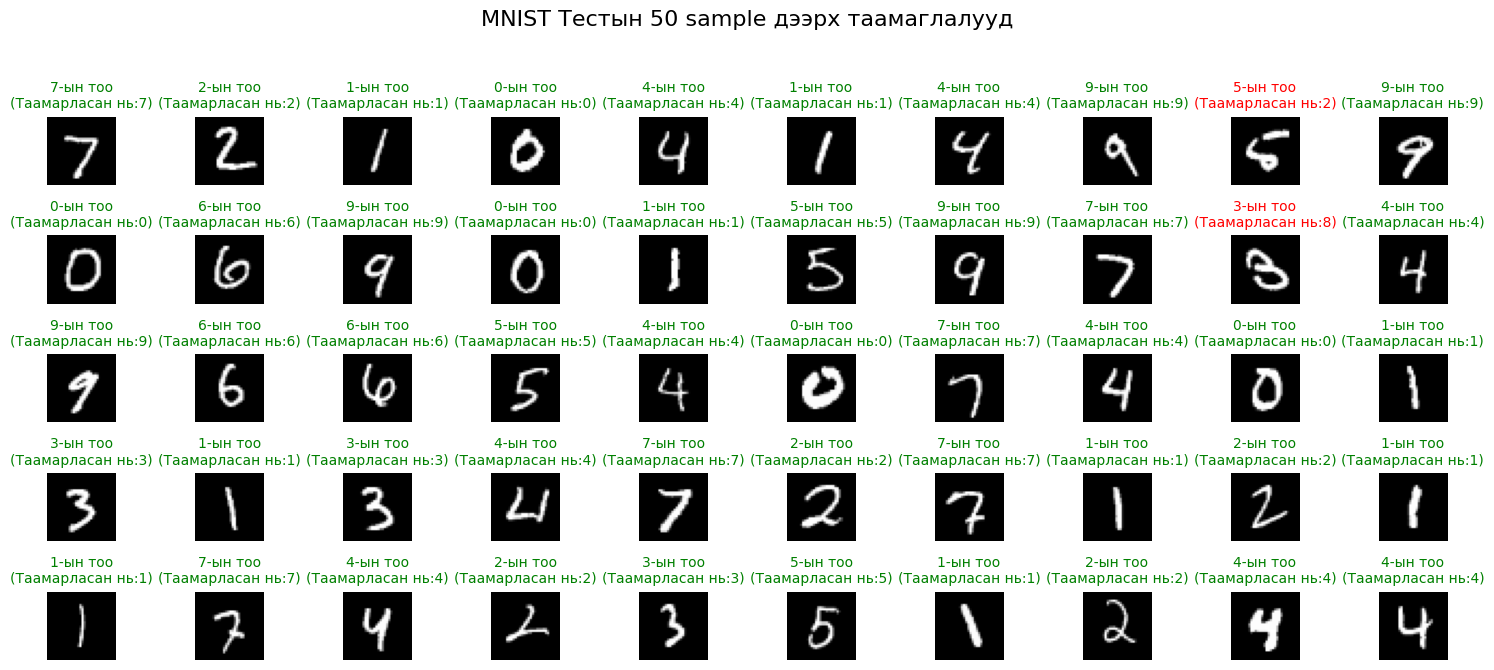

In [ ]:
net.eval()
import matplotlib.pyplot as plt
import numpy as np

test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = net(inputs)
        loss = criterion(output, labels)
        test_loss += loss.item()

        _, predict = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item()

print("\n- - - ТЕСТ - - -")
print(f"Тестын лосс: {test_loss/len(testloader):.4f}")
print(f"Тестын оновчтой байдал: {100*correct/total:.2f}%")


print("\n- - - 50 samples дээрх жишээ - - -")
#testloader-г шинэчлэх нь
vis_testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform_test
)
vis_loader = torch.utils.data.DataLoader(
    vis_testset, batch_size=50, shuffle=False, num_workers=2
)
#plot хийхэд хэрэг болохоор de-normalize хийх нь
def denormalizer(tensor):
    mean = torch.tensor(MNIST_MEAN).view(1, 1, 1)
    std = torch.tensor(MNIST_STD).view(1, 1, 1)
    tensor = tensor * std.to(tensor.device) + mean.to(tensor.device)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

with torch.no_grad():
    dataiter = iter(vis_loader)
    img, trueLabel = next(dataiter)
    img = img.to(device)
    output = net(img)
    _, predictedLabel = torch.max(output.data, 1)

    imgDenorm = denormalizer(img.cpu()).numpy()
    trueLabelNp = trueLabel.numpy()
    predictedLabelNp = predictedLabel.cpu().numpy()

    fig, axes = plt.subplots(5, 10, figsize=(15, 7))
    axes = axes.flatten()

    for i in range(50):
        img = imgDenorm[i].squeeze() 
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        true_label = trueLabelNp[i]
        predicted_label = predictedLabelNp[i]

        title = f"{true_label}-ын тоо\n(Таамарласан:{predicted_label})"
        color = 'green' if true_label == predicted_label else 'red'
    
        ax.set_title(title, fontsize=10, color=color)
        ax.axis('off')

    plt.suptitle("MNIST Тестын 50 sample дээрх таамаглалууд", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [3]:
checkpoint = torch.load("checkpoint_epoch_30.pth", map_location=device)

net.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

start_epoch = checkpoint["epoch"] + 1  # Continue from next epoch
print("Resuming training from epoch:", start_epoch)

Resuming training from epoch: 30


C:\Users\Colorful\AppData\Local\Temp\ipykernel_9496\344080668.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_epoch_30.pth", map_loca